# Car Classification Modeling and Evaluation

### Task

Download the dataset on car evaluations from http://archive.ics.uci.edu/ml/datasets/Car+Evaluation. 

Among the basic classification techniques that you are familiar with (i.e., decision tree, k-NN, logistic regression, NB, SVM) use all that would be applicable to this dataset to predict the evaluation of the cars based on their characteristics. Explore how well these techniques perform for several different parameter values. 

Present a brief overview of your predictive modeling process, explorations, and discuss your results. Present your final model (i.e., the best predictive model that you were able to come up with), and discuss its performance in a comprehensive manner (overall accuracy; per-class performance, i.e., whether this model predicts all classes equally well, or if there some classes for which it does much better than others; etc.).  

### Process Overview

Problems present in the dataset:

1)	Binary vs Ordinal data
2)	Multiclass target variable
3)	Imbalanced target variables

Challenges to overcome:

		Selecting a metric when the data is imbalanced is difficult. Accuracy would not be an acceptable measurement for imbalanced data, it could predict every sample as the dominant class and would return a high accuracy score. For this dataset, the main metric of focus will be MCC which will give a more balanced view of how the model performs for all classes. MCC will help us to capture both types of errors for more reliability than accuracy as it will consider the entire confusion matrix. Using MCC with a second opinion from F1 will be beneficial for both binary and multiclass classification. 
        
		The pros of changing the input variables to numerical are that some models are more compatible with models such as logistic regression, decision trees, and SVM. Additionally, the distance model (KNN) will be able to consider the ordinal information of which class is further from each other. Overall changing the numerical input variables is helpful for capturing relationships for ordinal data. The con of numerical encoding is that it may lose meaning in categorical data or have information loss. 
        
		The pro to binary transformation is that it is simple and efficient when you have categorical data. It will work well with decision trees or other tree-based models. The major downside is that we may lose information in ordinal data. Additionally, multiclass variables tend to complicate the process, there can be misinterpretation along the way.
        
		With the multiclass target variable, there are different ways to run analysis. There is the one versus one method or one versus many. One versus one method would be more beneficial when the number of classes are small as it would turn out to be N*(N-2)/2. One versus many would be better for many classes in addition to unbalanced data sets. Since this dataset only has 4, one versus one would be more beneficial.
		
Overview:

    To build the best model, MCC is chosen as the priority metric while F1, Recall, and Precision are all considered second. Because of the imbalanced data, accuracy will not be an important metric. To start, the data will be split into training and testing sets. From there, the training data will be converted into two data sets: one for categorical classification (binary) and one for ordinal classification (numerical). I will run Decision Tree, KNN, SVM, logistic regression, and naïve bayes on both the binary and numerical data sets with nested CV. 

    As the data is moderately imbalanced, some models will need additional hyperparameters and pre-processing to help balance the dataset. KNN and logistic regression will use smote to help balance the dataset. SVM will use class weight to help with the imbalanced data. Additionally, all models were trained as one versus the rest, this is to help combat the imbalanced data. 

    Finally, I will select the best model from nested cross validation based off MCC scores. The best model will go through hyperparameter tuning and be tested on the remaining holdout data. 


## Import the data

In [7]:
# !pip install ucimlrepo

In [8]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
  
# variable information 
print(car_evaluation.variables) 

       name     role         type demographic  \
0    buying  Feature  Categorical        None   
1     maint  Feature  Categorical        None   
2     doors  Feature  Categorical        None   
3   persons  Feature  Categorical        None   
4  lug_boot  Feature  Categorical        None   
5    safety  Feature  Categorical        None   
6     class   Target  Categorical        None   

                                         description units missing_values  
0                                       buying price  None             no  
1                           price of the maintenance  None             no  
2                                    number of doors  None             no  
3              capacity in terms of persons to carry  None             no  
4                           the size of luggage boot  None             no  
5                        estimated safety of the car  None             no  
6  evaulation level (unacceptable, acceptable, go...  None             no  

#### | class values

unacc, acc, good, vgood

#### | attributes

buying:   vhigh, high, med, low.

maint:    vhigh, high, med, low.

doors:    2, 3, 4, 5more.

persons:  2, 4, more.

lug_boot: small, med, big.

safety:   low, med, high.


## Inspect Data for Null Values and Inconsistencties

In [11]:
# Checking for NA values
xna = X.isna().sum()
yna = y.isna().sum()

print("x:", xna, "y:", yna)

x: buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
dtype: int64 y: class    0
dtype: int64


In [12]:
# Evaluate the features
X.describe()

,buying,maint,doors,persons,lug_boot,safety
count,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3
top,vhigh,vhigh,2,2,small,low
freq,432,432,432,576,576,576


In [13]:
# Evaluate the targets
y.describe()

,class
count,1728
unique,4
top,unacc
freq,1210


In [14]:
# Check the class distribution
unique_count = y.value_counts()
unique_count

class
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

In [15]:
# Class imbalances
unacc = 1210/1728
unacc

0.7002314814814815

## Split the data before Transformation

In [17]:
import pandas as pd

# Split into training and testing data, 80% training, 20% testing
from sklearn.model_selection import cross_val_score, train_test_split
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=.2,random_state=100)

### Binary Transformation

In [19]:
from sklearn.preprocessing import OneHotEncoder
x_encoder = OneHotEncoder()
X_bin_train = x_encoder.fit_transform(X_train_cv).toarray()
X_bin_train

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [20]:
# Just checking to make sure its correct
X_bin_train= pd.DataFrame(X_bin_train, columns=x_encoder.get_feature_names_out())
X_bin_train.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [21]:
# Now for y transformation
y_bin_train = pd.DataFrame(y_train_cv)

### Ordinal Transformation

In [23]:
# Convert to DataFrame
X_ord_train = pd.DataFrame(X_train_cv)

# Define the mappings
buying_map = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
maint_map = {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1}
doors_map = {'2': 1, '3': 2, '4': 3, '5more': 4}
persons_map = {'2': 1, '4': 2, 'more': 3}
lug_boot_map = {'small': 1, 'med': 2, 'big': 3}
safety_map = {'low': 1, 'med': 2, 'high': 3}

# Apply the mappings
X_ord_train['buying'] = X_ord_train['buying'].map(buying_map)
X_ord_train['maint'] = X_ord_train['maint'].map(maint_map)
X_ord_train['doors'] = X_ord_train['doors'].map(doors_map)
X_ord_train['persons'] = X_ord_train['persons'].map(persons_map)
X_ord_train['lug_boot'] = X_ord_train['lug_boot'].map(lug_boot_map)
X_ord_train['safety'] = X_ord_train['safety'].map(safety_map)
X_ord_train.head(10)

,buying,maint,doors,persons,lug_boot,safety
1513,1,2,1,1,1,2
1466,1,3,3,1,3,3
103,4,4,4,3,2,2
1707,1,1,4,1,3,1
1479,1,3,3,3,2,1
916,2,4,2,3,3,2
985,2,3,1,2,2,2
1611,1,2,4,3,1,1
898,2,4,2,1,3,2
368,4,1,2,2,3,3


In [24]:
# Do the same for Y
y_ord_train = pd.DataFrame(y_train_cv)

## Set Up

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score,matthews_corrcoef
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB

## Nested CV Function

In [28]:
# Create nested cv classifcation function to call later
def nested_cv(model_pipeline, param_grid, X_train, y_train, outer_splits=5, inner_splits=5):

    # Define outer CV for model performance
    outer_cv = StratifiedKFold(n_splits= outer_splits, shuffle=True, random_state=42)

    # Set lists for scores to append later
    accuracy_scores, recall_scores, precision_scores , f1_scores, mcc_scores = [], [], [], [], []

    for train_idx, test_idx in outer_cv.split(X_train, y_train):
        # Split outer train/test data
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

        # GridSearchCV for tuning
        grid_search = GridSearchCV(model_pipeline, param_grid, cv=inner_cv, scoring='matthews_corrcoef', refit=True)
        grid_search.fit(X_train_fold, y_train_fold.to_numpy().ravel())

        # Best model from inner loop
        best_model = grid_search.best_estimator_

        # Predict on outer test set
        y_pred = best_model.predict(X_test_fold)

        # Calculate different performance metrics
        accuracy = accuracy_score(y_test_fold.to_numpy().ravel(), y_pred)
        recall = recall_score(y_test_fold.to_numpy().ravel(), y_pred, average='weighted')
        precision = precision_score(y_test_fold.to_numpy().ravel(), y_pred, average='weighted')
        f1 = f1_score(y_test_fold.to_numpy().ravel(), y_pred, average='weighted')
        mcc = matthews_corrcoef(y_test_fold.to_numpy().ravel(), y_pred)
        

        # Append scores for each fold
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        f1_scores.append(f1)
        mcc_scores.append(mcc)

    # Return mean metrics across outer folds
    return {
        'Nested CV Accuracy': float(np.mean(accuracy_scores)),
        'Nested CV Recall': float(np.mean(recall_scores)),
        'Nested CV Precision': float(np.mean(precision_scores)),
        'Nested CV F1 Score': float(np.mean(f1_scores)),
        'Nested CV MCC Score': float(np.mean(mcc_scores))
    }

### KNN

In [30]:
# Define the KNN model
model_knn = KNeighborsClassifier()

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Create an imbalanced-learn pipeline with SMOTE, scaling, and the One-vs-Rest KNN model
pipeline_knn = ImPipeline([
    ('smote', smote),  # Apply SMOTE to balance the data
    ('scaler', StandardScaler()),  # Normalize data
    ('knn', OneVsRestClassifier(KNeighborsClassifier()))  # One-vs-Rest classifier
])

# Define the parameter grid for hyperparameter tuning (inner loop)
param_grid_knn = {
    'knn__estimator__n_neighbors': [5, 7, 10, 15],  
    'knn__estimator__metric': ['euclidean', 'manhattan'],
    'knn__estimator__weights': ['uniform', 'distance']
}

# Binary model results
bin_results_knn = nested_cv(pipeline_knn, param_grid_knn, X_bin_train, y_bin_train)
print("KNN Binary:", bin_results_knn)

# Ordinal model results
ord_results_knn = nested_cv(pipeline_knn, param_grid_knn, X_ord_train, y_ord_train)
print("KNN Ordinal:", ord_results_knn)


C:\Users\olivi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\olivi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\olivi\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\olivi\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\olivi\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

KNN Binary: {'Nested CV Accuracy': 0.9066551561764244, 'Nested CV Recall': 0.9066551561764244, 'Nested CV Precision': 0.9178613869647199, 'Nested CV F1 Score': 0.9111772395803104, 'Nested CV MCC Score': 0.8066196495030482}
KNN Ordinal: {'Nested CV Accuracy': 0.899429707528907, 'Nested CV Recall': 0.899429707528907, 'Nested CV Precision': 0.9149342410685959, 'Nested CV F1 Score': 0.90299339502346, 'Nested CV MCC Score': 0.7997812012393511}


### SVM

In [32]:
# Create pipelines with normalization (scaling) and models
# Define the model
model_svm = SVC(class_weight = 'balanced', decision_function_shape = 'ovr')

# Create a pipeline with the model, no need to normalize on DT
pipeline_svm= Pipeline([
    ('scaler', StandardScaler()),  # Normalize data
    ('SVM', model_svm)  # SVM classifier
])

# Define the parameter grid for hyperparameter tuning
param_grid_svm = {
    'SVM__C': [0.1, 1, 10],   # Regularization strength
    'SVM__kernel': ['linear', 'rbf'],  # Type of kernel to use
    'SVM__gamma': ['scale', 0.1, 1, 10]  # Kernel coefficient
}

# Binary model results
bin_results_svm = nested_cv(pipeline_svm, param_grid_svm, X_bin_train, y_bin_train)
print("SVM Binary:", bin_results_svm)

# Ordinal model results
ord_results_svm = nested_cv(pipeline_svm, param_grid_svm, X_ord_train, y_ord_train)
print("SVM Binary:", ord_results_svm)

SVM Binary: {'Nested CV Accuracy': 0.9927614712499345, 'Nested CV Recall': 0.9927614712499345, 'Nested CV Precision': 0.9937023108883885, 'Nested CV F1 Score': 0.9928873487947885, 'Nested CV MCC Score': 0.9845013837727052}
SVM Binary: {'Nested CV Accuracy': 0.9783001098728615, 'Nested CV Recall': 0.9783001098728615, 'Nested CV Precision': 0.9806835910465864, 'Nested CV F1 Score': 0.9787461095048073, 'Nested CV MCC Score': 0.9547817060167645}


### Decision Tree

In [34]:
# Create pipelines with normalization (scaling) and models
# Define the model
model_dt = DecisionTreeClassifier()

# Create a pipeline with the model, no need to normalize on DT
pipeline_dt= ImPipeline([
    # ('smote', smote),
    ('DecisionTree', model_dt)  # Dt classifier
])

# Set parameter grid for search
param_grid_dt = {'DecisionTree__max_depth': [3, 5,7], 
                 'DecisionTree__min_samples_split': [3,5],
                 'DecisionTree__criterion': ['gini', 'entropy']}

# Binary model results
bin_results_dt = nested_cv(pipeline_dt, param_grid_dt, X_bin_train, y_bin_train)
print("Decision Tree Binary:", bin_results_dt)

# Ordinal model results
ord_results_dt = nested_cv(pipeline_dt, param_grid_dt, X_ord_train, y_ord_train)
print("Decision Tree Binary:", ord_results_dt)

Decision Tree Binary: {'Nested CV Accuracy': 0.9182179668288599, 'Nested CV Recall': 0.9182179668288599, 'Nested CV Precision': 0.9304395854006552, 'Nested CV F1 Score': 0.9182605782183245, 'Nested CV MCC Score': 0.8334383870145826}
Decision Tree Binary: {'Nested CV Accuracy': 0.9218490032961858, 'Nested CV Recall': 0.9218490032961858, 'Nested CV Precision': 0.9257551764286983, 'Nested CV F1 Score': 0.9217574297459483, 'Nested CV MCC Score': 0.8354384849608898}


### Logistic Regression

In [36]:
# Create pipelines with normalization (scaling) and models
# Define the model
model_lr = OneVsRestClassifier(
    LogisticRegression(class_weight='balanced', max_iter=5000, penalty='l2', solver='lbfgs')
)

# Define SMOTE for over sampling
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Create a pipeline with the model
pipeline_lr= ImPipeline([
    ('smote', smote),
    ('scaler', StandardScaler()),
    ('LR', model_lr)  
])

# Set parameter grid
param_grid_lr = {
    'LR__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'LR__estimator__solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga']
}

# Binary model results
bin_results_lr = nested_cv(pipeline_lr, param_grid_lr, X_bin_train, y_bin_train)
print("Logistic Regression Binary:", bin_results_lr)

# Ordinal model results
ord_results_lr = nested_cv(pipeline_lr, param_grid_lr, X_ord_train, y_ord_train)
print("Logistic Regression Binary:", ord_results_lr)

C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter 

Logistic Regression Binary: {'Nested CV Accuracy': 0.8422434991890336, 'Nested CV Recall': 0.8422434991890336, 'Nested CV Precision': 0.8884809067945474, 'Nested CV F1 Score': 0.8546962103283713, 'Nested CV MCC Score': 0.7127078695670513}
Logistic Regression Binary: {'Nested CV Accuracy': 0.7474362999005912, 'Nested CV Recall': 0.7474362999005912, 'Nested CV Precision': 0.8127042863592047, 'Nested CV F1 Score': 0.7676166834821807, 'Nested CV MCC Score': 0.5435937233405016}


### NB

In [38]:
# Define the Naive Bayes model
model_nb = GaussianNB()  # You could also use MultinomialNB() or BernoulliNB()

# Create the pipeline
pipeline_nb = ImPipeline([
    ('NB', model_nb)  # Naive Bayes classifier
])

# Define the hyperparameter grid (Naive Bayes usually doesn't have as many tunable parameters as other models)
param_grid_nb = {
    'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # var_smoothing is a common parameter for GaussianNB
}

# Binary model results
bin_results_nb = nested_cv(pipeline_nb, param_grid_nb, X_bin_train, y_bin_train)
print("Naive Bayes Binary:", bin_results_nb)

# Ordinal model results
ord_results_nb = nested_cv(pipeline_nb, param_grid_nb, X_ord_train, y_ord_train)
print("Naive Bayes Binary:", ord_results_nb)

Naive Bayes Binary: {'Nested CV Accuracy': 0.796664573850259, 'Nested CV Recall': 0.796664573850259, 'Nested CV Precision': 0.8655684816163495, 'Nested CV F1 Score': 0.8138001909719547, 'Nested CV MCC Score': 0.6493296776518579}
Naive Bayes Binary: {'Nested CV Accuracy': 0.7402370114581699, 'Nested CV Recall': 0.7402370114581699, 'Nested CV Precision': 0.7676530250506277, 'Nested CV F1 Score': 0.7255356827653199, 'Nested CV MCC Score': 0.4495383238234766}


### Model Summaries

Since MCC is a metric that considers all types of errors, it will be prioritized when selecting a model. However, SVM outperformed every model in both binary and ordinal datasets. From the results, almost all models performed better using binary data over numerical data. There is one exception and that is KNN, it performed better on the ordinal dataset as KNN is a distance-based model. Moving forward, SVM will be tuned to find its best hyperparameters and will be fitted to the entire training dataset for both categorical and numerical datasets. We will then test both datasets to see which dataset performs better. 

## Perform Hyperparameter Tuning on the Best Model

### Set Up

In [43]:
# Define the model with probability to true
model_svm = SVC(class_weight = 'balanced', decision_function_shape = 'ovr', probability = True)

# Create a pipeline with the model
pipeline_svm= Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Normalize data
    ('SVM', model_svm)  # SVM classifier
])

# Define the parameter grid for hyperparameter tuning
param_grid_svm = {
    'SVM__C': [0.1, 1, 10],   # Regularization strength
    'SVM__kernel': ['linear', 'rbf'],  # Type of kernel to use
    'SVM__gamma': ['scale', 0.1, 1, 10]  # Kernel coefficient
}

In [44]:
# Model training and tuning
def run_grid_search(X_train, y_train, pipeline, param_grid):
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='matthews_corrcoef',
        refit=True
    )
    grid.fit(X_train, y_train)
    return grid

In [45]:
# Final Evaluation
def evaluate_model(model, X_test, y_test, label=""):
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    recall = recall_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    mcc = matthews_corrcoef(y_test, y_pred)

    print(f"\n{label} Set Performance")
    print(f"Best Hyperparameters: {model.best_params_}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"MCC Score: {mcc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.best_estimator_.classes_)
    disp.plot(cmap='Blues')

In [46]:
# Ordinal Mapping
def apply_ordinal_mapping(df):
    maps = {
        'buying': {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1},
        'maint': {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1},
        'doors': {'2': 1, '3': 2, '4': 3, '5more': 4},
        'persons': {'2': 1, '4': 2, 'more': 3},
        'lug_boot': {'small': 1, 'med': 2, 'big': 3},
        'safety': {'low': 1, 'med': 2, 'high': 3}
    }
    for col, mapping in maps.items():
        df[col] = df[col].map(mapping)
    return df

#### Final Binary Model


Binary Set Performance
Best Hyperparameters: {'SVM__C': 10, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Accuracy:  0.9869
Recall:    0.9942
Precision: 0.9944
F1 Score:  0.9942
MCC Score: 0.9869


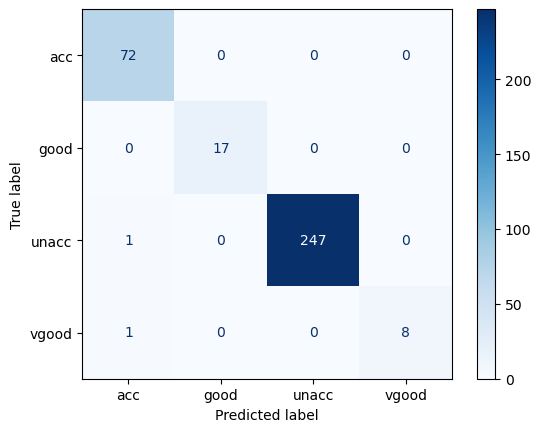

In [48]:
# Binary Transformation
X_bin_train_np = X_bin_train.values
y_bin_train_np = y_bin_train.values.ravel()
X_bin_test_np = OneHotEncoder(sparse_output=False).fit_transform(X_test_cv)
y_bin_test_np = y_test_cv.values.ravel()

# Binary results
grid_bin = run_grid_search(X_bin_train_np, y_bin_train_np, pipeline_svm, param_grid_svm)
evaluate_model(grid_bin, X_bin_test_np, y_bin_test_np, label="Binary")

### Final Ordinal Model

C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\olivi\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



Ordinal Set Performance
Best Hyperparameters: {'SVM__C': 10, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Accuracy:  0.9683
Recall:    0.9855
Precision: 0.9865
F1 Score:  0.9857
MCC Score: 0.9683


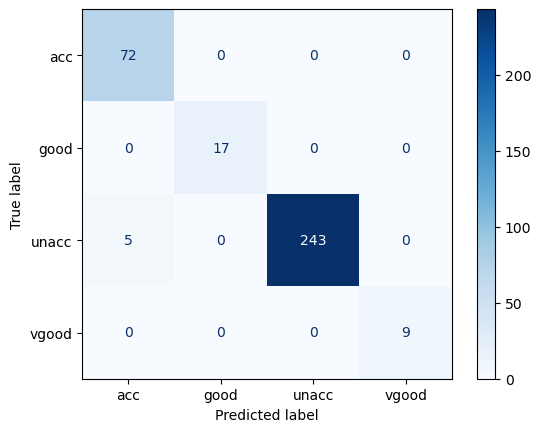

In [50]:
# Ordinal Transformation
X_ord_train_np = X_ord_train.values
y_ord_train_np = y_ord_train.values.ravel()
X_ord_test_df = apply_ordinal_mapping(pd.DataFrame(X_test_cv))
y_ord_test_np = y_test_cv.values.ravel()

# Ordinal Results
grid_ord = run_grid_search(X_ord_train_np, y_ord_train_np, pipeline_svm, param_grid_svm)
evaluate_model(grid_ord, X_ord_test_df, y_ord_test_np, label="Ordinal")

## Final SVM Model Summary

Both the binary and ordinal SVM models selected a regularization strength of C = 10, indicating a lower tolerance for misclassification and a preference for a more complex decision boundary. This likely reflects the use of Matthews Correlation Coefficient (MCC) as the tuning metric, which strongly penalizes misclassified examples in imbalanced settings.

Both models also selected the RBF kernel with gamma set to 'scale', which adapts based on the input feature variance. Because the ordinal dataset uses label encoding (with larger feature magnitudes) compared to the one-hot encoded binary dataset, the effective gamma value would be smaller for the ordinal model, not larger.

Overall, the binary model outperformed the ordinal model across all metrics, achieving an MCC score of 0.9869 versus 0.9683. This is expected, as binary classification typically yields better performance than multi-class classification—particularly when classes are well-separated. The binary model also achieved near-perfect recall, precision, and F1 score, which aligns with a clean confusion matrix dominated by correct predictions.